In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   frame.number      ip.src  tcp.srcport  mqtt.clientid  mqtt.msgid  label
0             1  10.6.56.36      47590.0            0.0         0.0      0
1             2   10.6.56.1       1883.0            0.0         0.0      0
2             3  10.6.56.36      47588.0            0.0         0.0      0
3             4   10.6.56.1       1883.0            0.0         0.0      0
4             5  10.6.56.36      47592.0            0.0         0.0      0
Index(['frame.number', 'ip.src', 'tcp.srcport', 'mqtt.clientid', 'mqtt.msgid',
       'label'],
      dtype='object')
Class weights: {0: 0.5026224208738104, 1: 95.83176100628931}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7018 - loss: 1.9760 - val_accuracy: 0.6901 - val_loss: 1.6927
Epoch 2/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8692 - loss: 0.3279 - val_accuracy: 0.9338 - val_loss: 0.5807
Epoch 3/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9649 - loss: 0.1652 - val_accuracy: 0.9463 - val_loss: 0.4290
Epoch 4/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9564 - loss: 0.1796 - val_accuracy: 0.9355 - val_loss: 0.5068
Epoch 5/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9668 - loss: 0.1489 - val_accuracy: 0.9440 - val_loss: 0.4638
Epoch 6/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9655 - loss: 0.1508 - val_accuracy: 0.9359 - val_loss: 0.5098
3790/3790 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Combined Model Performance
Train ROC-AUC: 1.0
Val ROC-AUC: 0.9954367288860608
Test 

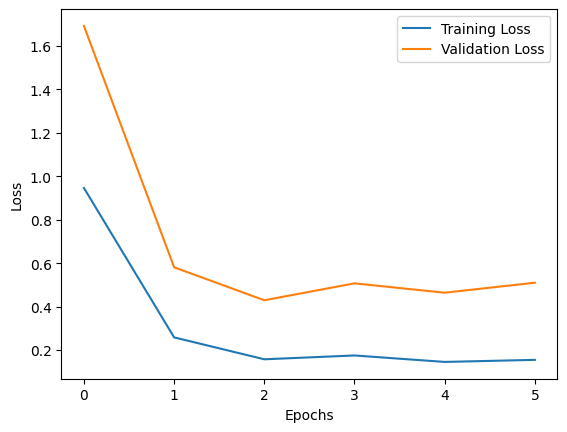

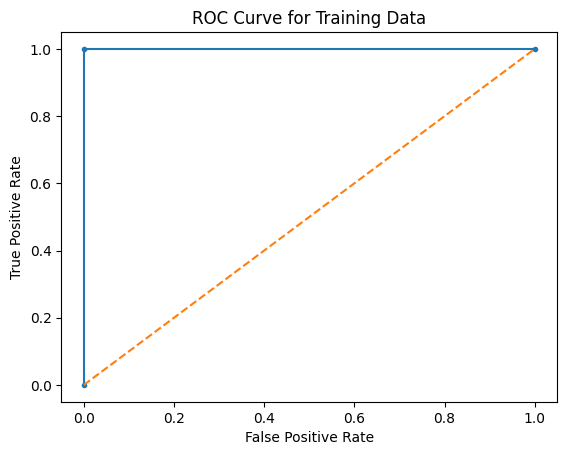

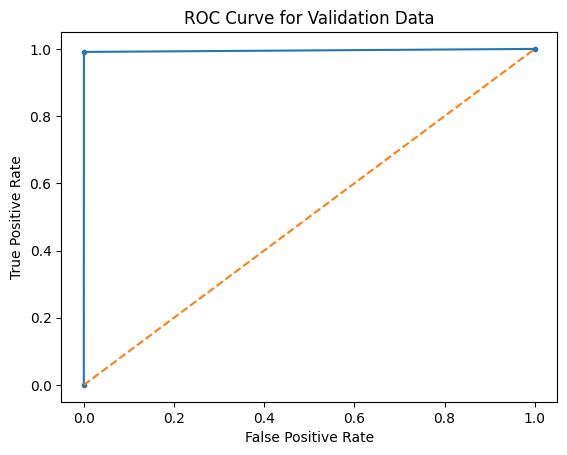

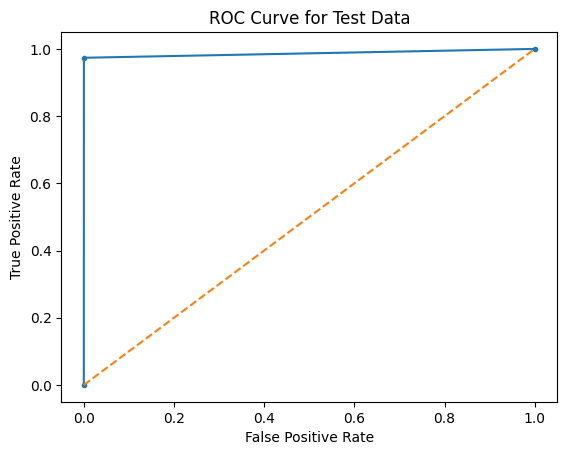

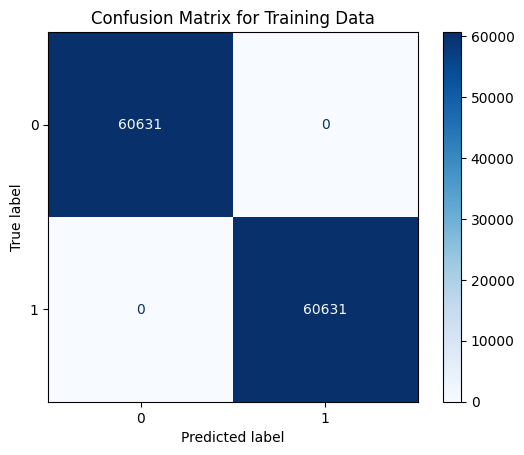

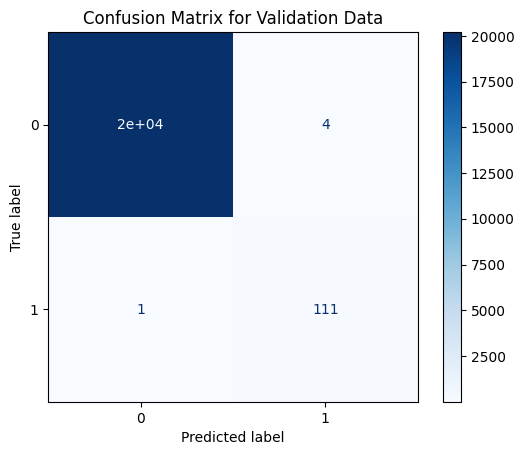

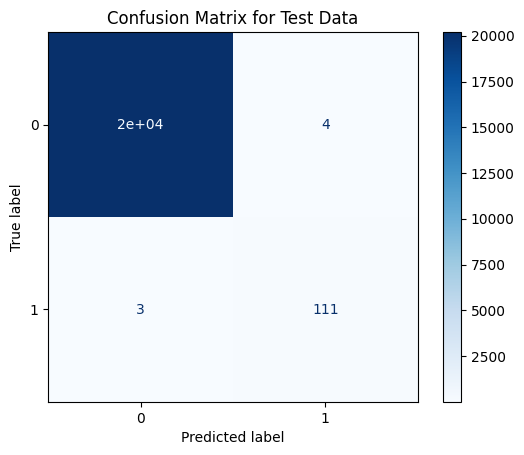

In [21]:
#RNN Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Preprocess the data
def preprocess_data(data):
    data['mqtt.clientid'] = data['mqtt.clientid'].fillna(0)
    data['mqtt.msgid'] = data['mqtt.msgid'].fillna(0)
    data['ip.src'] = data['ip.src'].astype(str)
    encoder = OneHotEncoder()
    ip_encoded = encoder.fit_transform(data[['ip.src']]).toarray()
    ip_encoded_df = pd.DataFrame(ip_encoded, columns=encoder.get_feature_names_out(['ip.src']))
    scaler = StandardScaler()
    data[['tcp.srcport', 'mqtt.clientid', 'mqtt.msgid']] = scaler.fit_transform(data[['tcp.srcport', 'mqtt.clientid', 'mqtt.msgid']])
    data['label'] = data['label'].astype(int)
    data.reset_index(drop=True, inplace=True)
    ip_encoded_df.reset_index(drop=True, inplace=True)
    features = pd.concat([data.drop(['ip.src', 'label'], axis=1), ip_encoded_df], axis=1)
    return features, data['label']

# Load the data from CSV files
files = [
    '/content/drive/MyDrive/capture_1910210000_labels.csv',
    '/content/drive/MyDrive/capture_1910220000_labels.csv',
    '/content/drive/MyDrive/capture_1910230000_labels.csv',
    '/content/drive/MyDrive/capture_1910240000_labels.csv',
    '/content/drive/MyDrive/capture_1910250000_labels.csv',
    '/content/drive/MyDrive/capture_1910260000_labels.csv',
    '/content/drive/MyDrive/capture_1910270000_labels.csv',
]

data = pd.concat([pd.read_csv(file, delimiter=';') for file in files])

# Fill missing values with 0
data.fillna(0, inplace=True)

# Display the first few rows of the dataset and its column names
print(data.head())
print(data.columns)

# Preprocess the data
X, y = preprocess_data(data)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_smote)
y_pred_train_iso = iso_forest.predict(X_train_smote)
y_pred_train_iso = np.where(y_pred_train_iso == 1, 0, 1)  # Convert from {1, -1} to {0, 1}
y_pred_val_iso = iso_forest.predict(X_val)
y_pred_val_iso = np.where(y_pred_val_iso == 1, 0, 1)
y_pred_test_iso = iso_forest.predict(X_test)
y_pred_test_iso = np.where(y_pred_test_iso == 1, 0, 1)

# Reshape data for LSTM
X_train_reshaped = np.expand_dims(X_train_smote, axis=2)
X_val_reshaped = np.expand_dims(X_val, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the LSTM model with class weights
history_lstm = lstm_model.fit(X_train_reshaped, y_train_smote, epochs=100, batch_size=64, validation_data=(X_val_reshaped, y_val), verbose=1, class_weight=class_weights_dict, callbacks=[early_stopping])

# Predict using LSTM model
y_pred_train_lstm = (lstm_model.predict(X_train_reshaped) > 0.5).astype(int)
y_pred_val_lstm = (lstm_model.predict(X_val_reshaped) > 0.5).astype(int)
y_pred_test_lstm = (lstm_model.predict(X_test_reshaped) > 0.5).astype(int)

# Combine predictions using majority voting
y_pred_train_combined = (y_pred_train_iso + y_pred_train_lstm.flatten() + rf_model.predict(X_train_smote)) > 1
y_pred_val_combined = (y_pred_val_iso + y_pred_val_lstm.flatten() + rf_model.predict(X_val)) > 1
y_pred_test_combined = (y_pred_test_iso + y_pred_test_lstm.flatten() + rf_model.predict(X_test)) > 1

# Evaluate the combined model
print("Combined Model Performance")
print(f"Train ROC-AUC: {roc_auc_score(y_train_smote, y_pred_train_combined)}")
print(f"Val ROC-AUC: {roc_auc_score(y_val, y_pred_val_combined)}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_test_combined)}")
print(f"Test F1-score: {f1_score(y_test, y_pred_test_combined)}")
print(f"Test Precision: {precision_score(y_test, y_pred_test_combined)}")
print(f"Test Recall: {recall_score(y_test, y_pred_test_combined)}")

# Plot training history for LSTM
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ROC curves
def plot_roc_curve(y_true, y_pred, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

plot_roc_curve(y_train_smote, y_pred_train_combined, 'ROC Curve for Training Data')
plot_roc_curve(y_val, y_pred_val_combined, 'ROC Curve for Validation Data')
plot_roc_curve(y_test, y_pred_test_combined, 'ROC Curve for Test Data')

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train_smote, y_pred_train_combined, 'Confusion Matrix for Training Data')
plot_confusion_matrix(y_val, y_pred_val_combined, 'Confusion Matrix for Validation Data')
plot_confusion_matrix(y_test, y_pred_test_combined, 'Confusion Matrix for Test Data')


Class distribution before SMOTE:
label
0    101039
1       544
Name: count, dtype: int64
Class weights: {0: 0.5026224208738104, 1: 95.83176100628931}
Class distribution after SMOTE:
label
0    60631
1    60631
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Random Forest Parameters: {'class_weight': {0: 0.5026224208738104, 1: 95.83176100628931}, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4998 - loss: 15350.2812 - val_accuracy: 0.0055 - val_loss: 3.9600
Epoch 2/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4977 - loss: 87.4034 - val_accuracy: 0.0055 - val_loss: 5.7139
Epoch 3/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5035 - loss: 22.1894 - val_accuracy: 0.0055 - val_loss: 6.3076
Epoch 4/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4990 - loss: 9.4295 - val_accuracy: 0.0055 - val_loss: 6.2383
Epoch 5/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5009 - loss: 4.6672 - val_accuracy: 0.0055 - val_loss: 6.0618
Epoch 6/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5018 - loss: 2.5681 - val_accuracy: 0.0055 - val_loss: 5.9786
Epoch 7/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4991 - loss: 2.3838 - val_accuracy: 0.0055 - val_loss: 5.9122
Epoch 8/100
1895/1895 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5002 - l

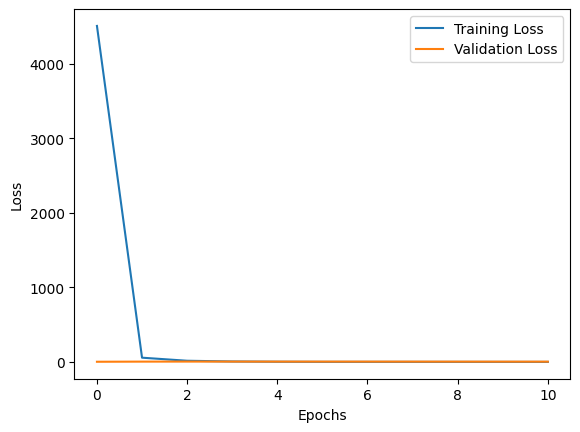

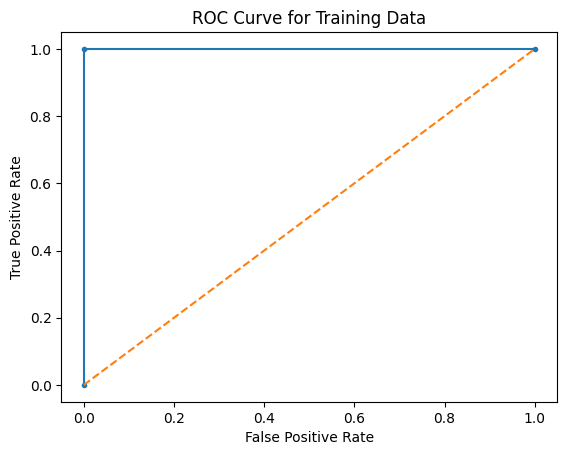

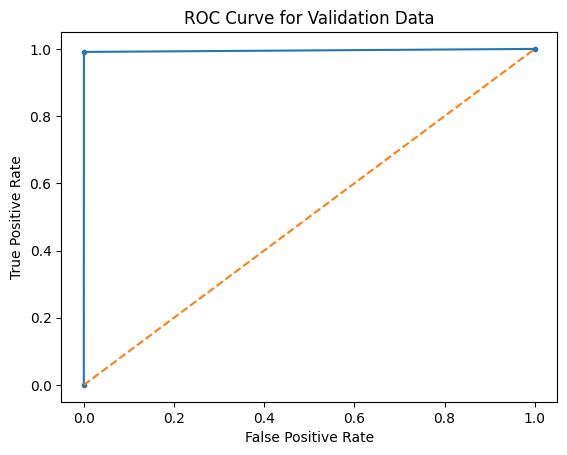

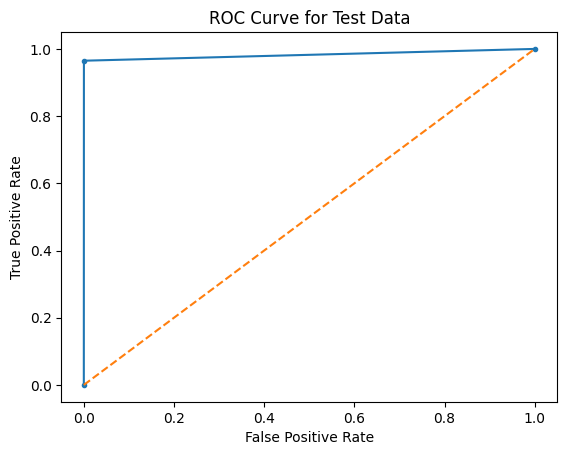

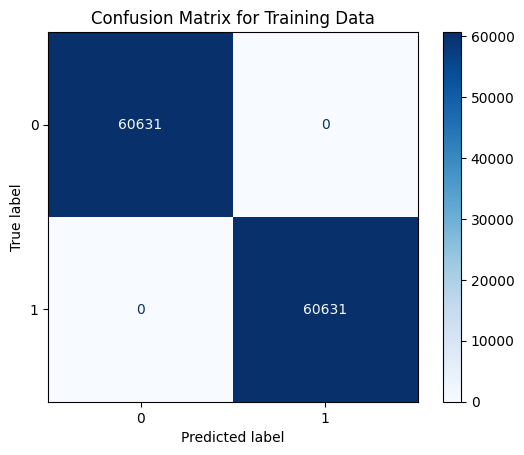

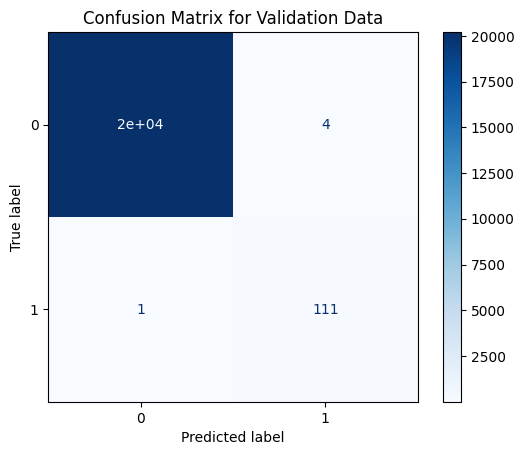

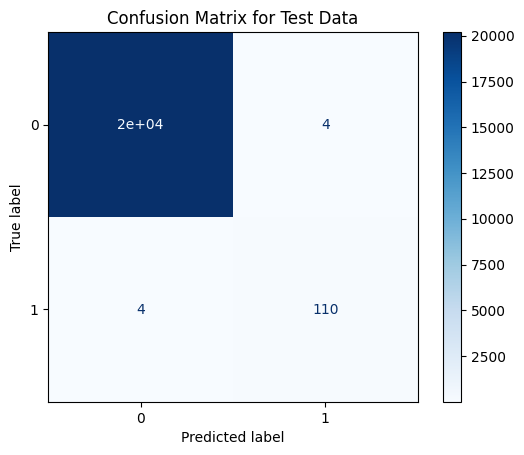

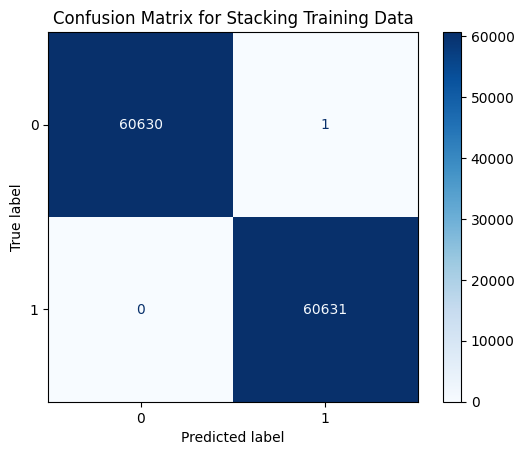

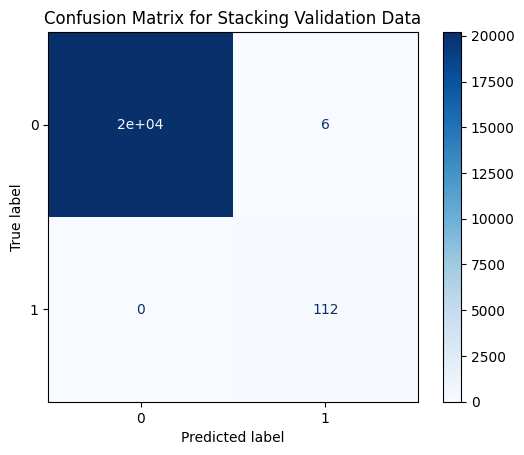

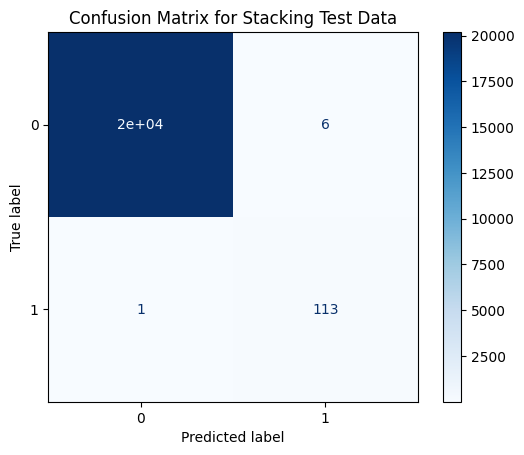

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression


# Preprocess the data
def preprocess_data(data):
    data['mqtt.clientid'] = data['mqtt.clientid'].fillna(0)
    data['mqtt.msgid'] = data['mqtt.msgid'].fillna(0)
    data['ip.src'] = data['ip.src'].astype(str)
    encoder = OneHotEncoder()
    ip_encoded = encoder.fit_transform(data[['ip.src']]).toarray()
    ip_encoded_df = pd.DataFrame(ip_encoded, columns=encoder.get_feature_names_out(['ip.src']))
    scaler = StandardScaler()
    data[['tcp.srcport', 'mqtt.clientid', 'mqtt.msgid']] = scaler.fit_transform(data[['tcp.srcport', 'mqtt.clientid', 'mqtt.msgid']])
    data['label'] = data['label'].astype(int)
    data.reset_index(drop=True, inplace=True)
    ip_encoded_df.reset_index(drop=True, inplace=True)
    features = pd.concat([data.drop(['ip.src', 'label'], axis=1), ip_encoded_df], axis=1)
    return features, data['label']

# Load the data from CSV files
files = [
    '/content/drive/MyDrive/capture_1910210000_labels.csv',
    '/content/drive/MyDrive/capture_1910220000_labels.csv',
    '/content/drive/MyDrive/capture_1910230000_labels.csv',
    '/content/drive/MyDrive/capture_1910240000_labels.csv',
    '/content/drive/MyDrive/capture_1910250000_labels.csv',
    '/content/drive/MyDrive/capture_1910260000_labels.csv',
    '/content/drive/MyDrive/capture_1910270000_labels.csv',
]

data = pd.concat([pd.read_csv(file, delimiter=';') for file in files])

# Fill missing values with 0
data.fillna(0, inplace=True)

# Preprocess the data
X, y = preprocess_data(data)

# Print out the class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts())

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print out the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Hyperparameter tuning for Random Forest using GridSearchCV
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [class_weights_dict]
}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)
print(f"Best Random Forest Parameters: {rf_model.best_params_}")

# Train XGBoost model with manual hyperparameter tuning
xgb_model = XGBClassifier(
    scale_pos_weight=class_weights_dict[1],
    max_depth=6,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train_smote, y_train_smote)

# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_smote)
y_pred_train_iso = iso_forest.predict(X_train_smote)
y_pred_train_iso = np.where(y_pred_train_iso == 1, 0, 1)  # Convert from {1, -1} to {0, 1}
y_pred_val_iso = iso_forest.predict(X_val)
y_pred_val_iso = np.where(y_pred_val_iso == 1, 0, 1)
y_pred_test_iso = iso_forest.predict(X_test)
y_pred_test_iso = np.where(y_pred_test_iso == 1, 0, 1)

# Reshape data for FNN (Flatten layer will handle reshaping internally)
X_train_reshaped = np.expand_dims(X_train_smote, axis=2)
X_val_reshaped = np.expand_dims(X_val, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Define FNN model with L2 regularization
fnn_model = Sequential([
    Flatten(input_shape=(X_train_smote.shape[1], 1)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.8),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.8),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

# Compile the FNN model
optimizer = Adam(learning_rate=0.001)
fnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
fnn_model.summary()

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the FNN model with class weights and early stopping
history_fnn = fnn_model.fit(
    X_train_reshaped,
    y_train_smote,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Predict probabilities using the FNN and XGBoost models
y_pred_train_fnn_proba = fnn_model.predict(X_train_reshaped)
y_pred_val_fnn_proba = fnn_model.predict(X_val_reshaped)
y_pred_test_fnn_proba = fnn_model.predict(X_test_reshaped)

y_pred_train_xgb_proba = xgb_model.predict_proba(X_train_smote)[:, 1]
y_pred_val_xgb_proba = xgb_model.predict_proba(X_val)[:, 1]
y_pred_test_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Manually setting a more reasonable threshold (closer to 0.5)
manual_threshold = 0.5

# Use this threshold for final predictions
y_pred_train_fnn = (y_pred_train_fnn_proba > manual_threshold).astype(int)
y_pred_val_fnn = (y_pred_val_fnn_proba > manual_threshold).astype(int)
y_pred_test_fnn = (y_pred_test_fnn_proba > manual_threshold).astype(int)

y_pred_train_xgb = (y_pred_train_xgb_proba > manual_threshold).astype(int)
y_pred_val_xgb = (y_pred_val_xgb_proba > manual_threshold).astype(int)
y_pred_test_xgb = (y_pred_test_xgb_proba > manual_threshold).astype(int)

# Combine predictions using majority voting
y_pred_train_combined = (y_pred_train_iso + y_pred_train_fnn.flatten() + y_pred_train_xgb + rf_model.predict(X_train_smote)) > 2
y_pred_val_combined = (y_pred_val_iso + y_pred_val_fnn.flatten() + y_pred_val_xgb + rf_model.predict(X_val)) > 2
y_pred_test_combined = (y_pred_test_iso + y_pred_test_fnn.flatten() + y_pred_test_xgb + rf_model.predict(X_test)) > 2


# Create a Stacking Classifier for ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_model.best_estimator_),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train_smote, y_train_smote)

# Evaluate the combined model with the manually set threshold
print("Combined Model Performance after Manual Threshold Adjustment")
print(f"Train ROC-AUC: {roc_auc_score(y_train_smote, y_pred_train_combined)}")
print(f"Val ROC-AUC: {roc_auc_score(y_val, y_pred_val_combined)}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_test_combined)}")
print(f"Test F1-score: {f1_score(y_test, y_pred_test_combined)}")
print(f"Test Precision: {precision_score(y_test, y_pred_test_combined)}")
print(f"Test Recall: {recall_score(y_test, y_pred_test_combined)}")

# Evaluate the stacking model
stacking_train_preds = stacking_model.predict(X_train_smote)
stacking_val_preds = stacking_model.predict(X_val)
stacking_test_preds = stacking_model.predict(X_test)

print("\nStacking Model Performance")
print(f"Train ROC-AUC: {roc_auc_score(y_train_smote, stacking_train_preds)}")
print(f"Val ROC-AUC: {roc_auc_score(y_val, stacking_val_preds)}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, stacking_test_preds)}")
print(f"Test F1-score: {f1_score(y_test, stacking_test_preds)}")
print(f"Test Precision: {precision_score(y_test, stacking_test_preds)}")
print(f"Test Recall: {recall_score(y_test, stacking_test_preds)}")

# Plot training history for FNN
plt.plot(history_fnn.history['loss'], label='Training Loss')
plt.plot(history_fnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ROC curves
def plot_roc_curve(y_true, y_pred, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

plot_roc_curve(y_train_smote, y_pred_train_combined, 'ROC Curve for Training Data')
plot_roc_curve(y_val, y_pred_val_combined, 'ROC Curve for Validation Data')
plot_roc_curve(y_test, y_pred_test_combined, 'ROC Curve for Test Data')

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train_smote, y_pred_train_combined, 'Confusion Matrix for Training Data')
plot_confusion_matrix(y_val, y_pred_val_combined, 'Confusion Matrix for Validation Data')
plot_confusion_matrix(y_test, y_pred_test_combined, 'Confusion Matrix for Test Data')

plot_confusion_matrix(y_train_smote, stacking_train_preds, 'Confusion Matrix for Stacking Training Data')
plot_confusion_matrix(y_val, stacking_val_preds, 'Confusion Matrix for Stacking Validation Data')
plot_confusion_matrix(y_test, stacking_test_preds, 'Confusion Matrix for Stacking Test Data')
